## Wavelet Resampling
### Author: Zhizheng Wang

In [1]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Downsample

In [2]:
# Define file paths
train_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/train_downsampled.csv"
test_csv = "/content/drive/MyDrive/Colab_Notebooks/dataset/test.csv"

# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (4046, 2)
Test shape: (2056, 1)


In [3]:
image_to_label_map = dict(zip(train["image_ID"].values, train["label"].values))

unique_classes = train["label"].unique()
print("Unique classes:", unique_classes)
print("Number of unique classes:", len(unique_classes))

Unique classes: ['Swimming' 'Badminton' 'Wrestling' 'Cricket' 'Soccer' 'Karate' 'Tennis']
Number of unique classes: 7


<Axes: xlabel='label', ylabel='count'>

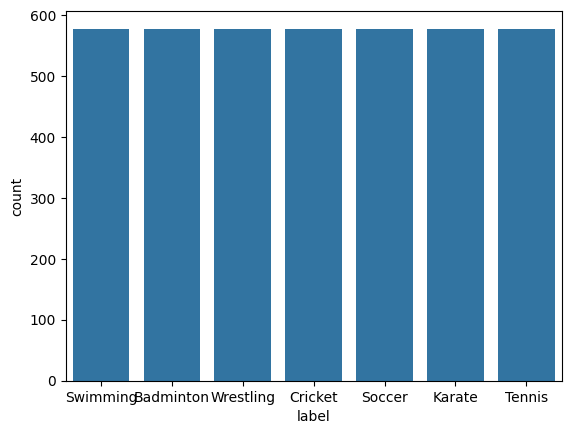

In [4]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [5]:
label_counts = train["label"].value_counts()
print(label_counts)

label
Swimming     578
Badminton    578
Wrestling    578
Cricket      578
Soccer       578
Karate       578
Tennis       578
Name: count, dtype: int64


## Resnet50

In [6]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [7]:
# 2. Split Data into Train and Validation Sets
train['label'] = pd.Categorical(train['label']).codes
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/downsampled/"
test_img_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/test/"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [8]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 102/102 [11:20<00:00,  6.67s/it]


Epoch [1/5], Training Loss: 1.5451, Training Accuracy: 0.4456


Epoch 1/5 - Validation: 100%|██████████| 26/26 [02:57<00:00,  6.84s/it]


Epoch [1/5], Validation Loss: 1.8910, Validation Accuracy: 0.4630


Epoch 2/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.54it/s]


Epoch [2/5], Training Loss: 1.1961, Training Accuracy: 0.5742


Epoch 2/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.68it/s]


Epoch [2/5], Validation Loss: 1.1745, Validation Accuracy: 0.5889


Epoch 3/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.10it/s]


Epoch [3/5], Training Loss: 1.0199, Training Accuracy: 0.6409


Epoch 3/5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


Epoch [3/5], Validation Loss: 1.1752, Validation Accuracy: 0.6062


Epoch 4/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.88it/s]


Epoch [4/5], Training Loss: 0.8386, Training Accuracy: 0.7142


Epoch 4/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.37it/s]


Epoch [4/5], Validation Loss: 1.3309, Validation Accuracy: 0.5370


Epoch 5/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.52it/s]


Epoch [5/5], Training Loss: 0.7420, Training Accuracy: 0.7420


Epoch 5/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.40it/s]

Epoch [5/5], Validation Loss: 1.2840, Validation Accuracy: 0.5926
Training completed.


Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8865


## VGG

In [9]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 231MB/s]


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.41it/s]


Epoch [1/5], Training Loss: 2.2752, Training Accuracy: 0.1465


Epoch 1/5 - Validation: 100%|██████████| 26/26 [00:03<00:00,  8.18it/s]


Epoch [1/5], Validation Loss: 1.9573, Validation Accuracy: 0.1346


Epoch 2/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.04it/s]


Epoch [2/5], Training Loss: 1.9557, Training Accuracy: 0.1456


Epoch 2/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.08it/s]


Epoch [2/5], Validation Loss: 1.9498, Validation Accuracy: 0.1444


Epoch 3/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.97it/s]


Epoch [3/5], Training Loss: 2.0503, Training Accuracy: 0.1363


Epoch 3/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.42it/s]


Epoch [3/5], Validation Loss: 1.9577, Validation Accuracy: 0.1444


Epoch 4/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.65it/s]


Epoch [4/5], Training Loss: 1.9539, Training Accuracy: 0.1372


Epoch 4/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch [4/5], Validation Loss: 1.9470, Validation Accuracy: 0.1444


Epoch 5/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.91it/s]


Epoch [5/5], Training Loss: 1.9524, Training Accuracy: 0.1452


Epoch 5/5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 12.95it/s]

Epoch [5/5], Validation Loss: 1.9458, Validation Accuracy: 0.1444
Training with VGG16 completed.


## GoogleNet

In [10]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 206MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.38it/s]


Epoch [1/5], Training Loss: 1.0159, Training Accuracy: 0.6554


Epoch 1/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.24it/s]


Epoch [1/5], Validation Loss: 0.8680, Validation Accuracy: 0.6926


Epoch 2/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.54it/s]


Epoch [2/5], Training Loss: 0.6137, Training Accuracy: 0.7880


Epoch 2/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.21it/s]


Epoch [2/5], Validation Loss: 1.0649, Validation Accuracy: 0.6716


Epoch 3/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.51it/s]


Epoch [3/5], Training Loss: 0.4605, Training Accuracy: 0.8473


Epoch 3/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.70it/s]


Epoch [3/5], Validation Loss: 0.5891, Validation Accuracy: 0.8284


Epoch 4/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.03it/s]


Epoch [4/5], Training Loss: 0.2749, Training Accuracy: 0.9098


Epoch 4/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.10it/s]


Epoch [4/5], Validation Loss: 0.7284, Validation Accuracy: 0.7827


Epoch 5/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.76it/s]


Epoch [5/5], Training Loss: 0.4455, Training Accuracy: 0.8548


Epoch 5/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s]


Epoch [5/5], Validation Loss: 0.7400, Validation Accuracy: 0.8074
Training with GoogLeNet completed.


## AlexNet

In [11]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 231MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.21it/s]


Epoch [1/5], Training Loss: 2.1184, Training Accuracy: 0.1425


Epoch 1/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.14it/s]


Epoch [1/5], Validation Loss: 1.9505, Validation Accuracy: 0.1358


Epoch 2/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.25it/s]


Epoch [2/5], Training Loss: 1.9497, Training Accuracy: 0.1409


Epoch 2/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s]


Epoch [2/5], Validation Loss: 1.9480, Validation Accuracy: 0.1358


Epoch 3/5 - Training: 100%|██████████| 102/102 [00:06<00:00, 14.63it/s]


Epoch [3/5], Training Loss: 1.9475, Training Accuracy: 0.1400


Epoch 3/5 - Validation: 100%|██████████| 26/26 [00:02<00:00, 12.93it/s]


Epoch [3/5], Validation Loss: 1.9474, Validation Accuracy: 0.1444


Epoch 4/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 13.15it/s]


Epoch [4/5], Training Loss: 1.9470, Training Accuracy: 0.1347


Epoch 4/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 14.16it/s]


Epoch [4/5], Validation Loss: 1.9476, Validation Accuracy: 0.1346


Epoch 5/5 - Training: 100%|██████████| 102/102 [00:07<00:00, 14.22it/s]


Epoch [5/5], Training Loss: 1.9472, Training Accuracy: 0.1292


Epoch 5/5 - Validation: 100%|██████████| 26/26 [00:01<00:00, 13.73it/s]

Epoch [5/5], Validation Loss: 1.9475, Validation Accuracy: 0.1346
Training with AlexNet completed.
